In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import  pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import arviz as az
from scipy.stats import norm, t
from sklearn.model_selection import train_test_split

def ppc(alpha,beta,sigma, X,  nsamples=500):
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

This Notebook was adapted from PyMC3 notebook examples.

# Model selection and averaging

When confronted with more than one model we have several options. One of them is to perform model selection. Model selection is appealing for its simplicity, but we are discarding information about the uncertainty in our models. 

Yet another approach is to perform model averaging. The idea now is to generate a meta-model (and meta-predictions) using a weighted average of the models. There are several ways to do this and PyMC3 includes 3 of them, you will find a more thorough explanation in the work by [Yuling Yao et. al.](https://arxiv.org/abs/1704.02030)

We will use Leave-one-out Cross-validation (LOO) which is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy using only the training dataset.

You have already see that for linear regression is possible to compute LOO directly from the training dataset and analytically:

    Abu-Mostafa, Yaser S., Malik Magdon-Ismail, and Hsuan-Tien Lin. Learning from data. AMLBook, 2012, see in particular pag. 150 (sec. 4.3).

For LOO, this formula is described here https://robjhyndman.com/hyndsight/loocv-linear-models/.
The amazing thing is that by using the posterior samples is possible to apply a simialr approach to any model, not just linear regression.



We will see it in a simple example: boston house pricing.
The goal is to determine a relationship between the price of houses in various places in Boston
and variables such as Crime rate (CRIM), areas of non-retail business in the town (INDUS), the age of people who own the house (AGE), etc.. 

We will define different models and compare them.





### Posterior predictive checks

We will also learn how to check the performance of a Probabilistic Machine Learning (PML) model.
For General Recipe ML, we use loss functions (mean squared error, accuracy, etc.). That is we evaluate the 
"prediction error" (quantified via the loss function) on unseen data.

In PML, we use posterior predictive checks, that is we use the posterior to simulate observations (values of the output variable) and compare the distribution of the simulated data against real-data.


In [3]:
#This is the dataset
from sklearn.datasets import load_boston
#input variables
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
#output variable
boston['MEDV'] = boston_dataset.target #price of the house, last column
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
#check if there are missing values
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [6]:
Val=  boston.values
boston.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

We consider three models by selecting a subset of the inputs:
* Model 1: features #4,5,6 
* Model 2: features #4,6,12
* Model 3: features #5,6,10

so for model 1 our model is

$$
MDEV = \alpha + \beta_1 NOX + \beta_2 	RM + \beta_3	AGE + noise
$$

so for model 2 our model is

$$
MDEV = \alpha + \beta_1 NOX + \beta_2 	AGE + \beta_3	LSTA + noise
$$

so for model 3 our model is

$$
MDEV = \alpha + \beta_1 RM + \beta_2 	AGE + \beta_3	PTRATIO + noise
$$

These are  linear regression models with partially different inputs, but same output variable MDEV.

We have also assumed that there is (observation) noise in our model. We may assume that the noise
is Gaussian with zero mean and variance $\sigma^2$.

$$
noise \sim Normal(0,\sigma^2)
$$

In [7]:
#Here we prepare our data and normalize it so all the inputs and output range in [-4,4] approximatively.
X1 = Val[:,[4,5,6]] #4,5,6
Y1 = Val[:,-1:]

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size = 0.2, random_state=42)

#we normalize inputs and outputs
x1_scaler= StandardScaler().fit(X_train1)
X_train1_n= x1_scaler.transform(X_train1)
y1_scaler= StandardScaler().fit(Y_train1)
Y_train1_n= y1_scaler.transform(Y_train1)

print(X_train1.shape)
print(X_test1.shape)
print(Y_train1.shape)
print(Y_test1.shape)

X2 = Val[:,[4, 6,12]] #4, 6,12
Y2 = Val[:,-1:]

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.2, random_state=42)

#we normalize inputs and outputs
x2_scaler= StandardScaler().fit(X_train2)
X_train2_n= x2_scaler.transform(X_train2)
y2_scaler= StandardScaler().fit(Y_train2)
Y_train2_n= y2_scaler.transform(Y_train2)


X3 = Val[:,[5,6,10]] #5,6,10
Y3 = Val[:,-1:]

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, Y3, test_size = 0.2, random_state=42)

#we normalize inputs and outputs
x3_scaler= StandardScaler().fit(X_train3)
X_train3_n= x3_scaler.transform(X_train3)
y3_scaler= StandardScaler().fit(Y_train3)
Y_train3_n= y3_scaler.transform(Y_train3)

(404, 3)
(102, 3)
(404, 1)
(102, 1)


### Model 1:
This is our probabilistic model for Model 1

In [8]:
with pm.Model() as model_1:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=X_train1_n.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
  
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, X_train1_n.T)
    #likelihood
    #case 1
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=Y_train1_n[:,0])# be sure that observed is a 1d vector
    #compute posterior
    posterior_1 = pm.sample(4000, tune=2000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma_n, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:04<00:00, 2415.81draws/s]


In [9]:
posterior_1['alpha'].shape

(8000,)

In [10]:
posterior_1['beta'].shape

(8000, 3)

In [11]:
posterior_1['sigma_n'].shape

(8000,)

In [12]:
X_train1_n.shape

(404, 3)

### How can we check the performance for this model
In this case we cannot plot the regression lines because we have three inputs.
However, we can still plot the posterior distribution at the training and test points as follows.

### Post-predictive check

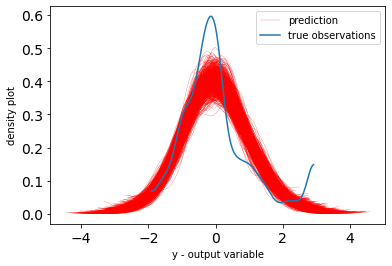

In [13]:
#TRAINING DATA
Ypred = ppc(posterior_1['alpha'],posterior_1['beta'],posterior_1['sigma_n'],X_train1_n,  nsamples=800)
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
az.plot_dist(Y_train1_n,label='true observations');
plt.legend()
plt.xlabel("y - output variable")
plt.ylabel("density plot");

The peak of the data is not covered by our probabilistic model. The issue is that the model puts too much weight on the tails. Maybe this holds because there are outliers in the dataset. A way to improve the model is to use a likelihood that does not weigh the outliers too much, Student-t.

In [14]:
with pm.Model() as model_1:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=X_train1_n.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
  
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, X_train1_n.T)
    #likelihood
    nu = pm.Exponential('nu', 1./10, testval = 5.)
    like = pm.StudentT('like',nu=nu, mu=mu, sd=sigma, observed=Y_train1_n[:,0])
    #compute posterior
    posterior_1 = pm.sample(4000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [nu, sigma_n, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1808.51draws/s]


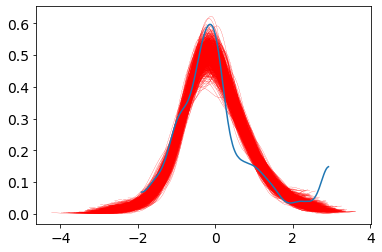

In [15]:
Ypred = ppc(posterior_1['alpha'],posterior_1['beta'],posterior_1['sigma_n'],X_train1_n,  nsamples=800)
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
az.plot_dist(Y_train1_n);

Posterior predictive checks means simulating replicated data from the posterior and then comparing these to the observed data. So, you use posterior predictive to look for systematic discrepancies between real and simulated data
and that is we did before. We do not want the the red lines and the blue line to be equal, but we only want to assess if our model gives us valid predictions about the reality. Posterior predictive checks is a helpful phase of model building and checking. 

Posterior predictive checks involve a double-use of the data, which is dangerous if then we make the prior over our parameters to "better fir the data".  Therefore,  posterior predictive checks can be used provided that usage is limited to measures of discrepancy to study model adequacy, not for model comparison.

In the latter case, we use instead **LOO**.

In [19]:
#compute LOO
model_1_loo = pm.loo(posterior_1)
model_1_loo

Computed from 8000 by 404 log-likelihood matrix

         Estimate       SE
elpd_loo  -361.40    22.33
p_loo        8.09        -

We are interested in `elpd_loo` that is the LOO estimate and `SE` is the relative standard error. The model returns the prediction accuracy so as higher as better.

Moreover, we can also run posterior-predictive checks on the test set and it is wise in particular when 
the test set asks us to do an extrapolation. That is to predict the output variable in correspondence of values
of the input that are "far" from the values of the inputs in the training set.

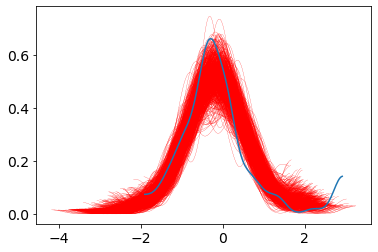

In [21]:
X_test1_n = x1_scaler.transform(X_test1) #AAA  Note that we are scaling also the test set
Y_test1_n = y1_scaler.transform(Y_test1)

Ypred = ppc(posterior_1['alpha'],posterior_1['beta'],posterior_1['sigma_n'],X_test1_n, nsamples=800)
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
az.plot_dist(Y_test1_n);

Note that the uncertainty, the envelope of all red lines is wider in this case. This is normal and correct because we are predicting unseen data and so our uncertainty should be higher. The model seems to be able to generate outputs that are similar to the real-ones. It works!

### Model 2:
This is our probabilistic model for Model 2

In [22]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta',   mu=0, sigma=30, shape=X_train2_n.shape[1])
    sigma = pm.HalfCauchy('sigma_n', 5)

    mu = alpha + pm.math.dot(beta, X_train2_n.T)


    nu = pm.Exponential('nu', 1./10, testval = 5.)
    like = pm.StudentT('like',nu=nu, mu=mu, sd=sigma, observed=Y_train2_n[:,0]) # be sure that observed is a 1d vector
    
    posterior_2 = pm.sample(4000, tune=2000, chains=2)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [nu, sigma_n, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1719.16draws/s]


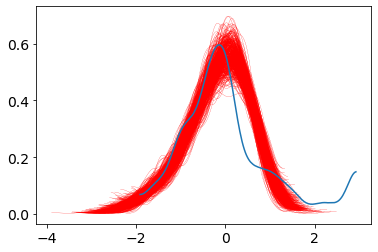

In [23]:
Ypred = ppc(posterior_2['alpha'],posterior_2['beta'],posterior_2['sigma_n'],X_train2_n,  nsamples=500)
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(y2_scaler.transform(Y_train2));

Note that in this case it is clear that the model is not able to output values of the $y$ variable (MEDV) that are greater than 2. All the red lines have this problem, so this model is not able to capture the uncertainty.
This means that the model is interpreting the observations for MEDV>2 as <a href="https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjhzJ-0kdrkAhUTWxUIHW0CCVEQFjAAegQIAxAB&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FOutlier&usg=AOvVaw0mQ6T_4WA-B443BrwL7Xwi"> outliers </a>. An outlier may be due to a measurement error and so it is correct to discard it. However, there are quite a lot of points  with  MEDV>2
(given the height of the blue line for  MEDV>2), so in this case they are more likely outputs that our model cannot simply explain.

There is clearly a design problem in our model: it assignes probability "zero" to values of the output variable that are larger than 2. Same in the test set below.

This a clear indication that the output-input model we are using

$$
MDEV = \alpha + \beta_1 NOX + \beta_2 	AGE + \beta_3	LSTA + noise
$$

is not right.

This means that:
* either the input variables we selected are not correct;
* or the model is not linear (should we use a neural network?).

In this case, we know that if we change the inputs we can predict values greater than 2 and so we will keep
the linearity assumption for our regression model.



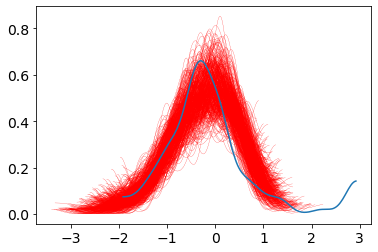

In [24]:
# we first normalize the test-points
X_test2_n = x2_scaler.transform(X_test2)
Y_test2_n = y2_scaler.transform(Y_test2)

Ypred = ppc(posterior_2['alpha'],posterior_2['beta'],posterior_2['sigma_n'],X_test2_n, nsamples=500)
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Y_test2_n[:,0]);

### LOO

In [26]:
#compute LOO
model_2_loo = pm.loo(posterior_2)
model_2_loo

Computed from 8000 by 404 log-likelihood matrix

         Estimate       SE
elpd_loo  -383.16    23.18
p_loo        7.31        -

In [27]:
print(model_1_loo,model_2_loo)

Computed from 8000 by 404 log-likelihood matrix

         Estimate       SE
elpd_loo  -361.40    22.33
p_loo        8.09        - Computed from 8000 by 404 log-likelihood matrix

         Estimate       SE
elpd_loo  -383.16    23.18
p_loo        7.31        -


This tells us that model 1 is better than model 2.

## Model 3

In [28]:
with pm.Model() as model_3:
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta',   mu=0, sigma=30, shape=X_train3_n.shape[1])
    sigma = pm.HalfCauchy('sigma_n', 5)

    mu = alpha + pm.math.dot(beta, X_train3_n.T)


    nu = pm.Exponential('nu', 1./10, testval = 5.)
    like = pm.StudentT('like',nu=nu, mu=mu, sd=sigma, observed=Y_train3_n[:,0]) # be sure that observed is a 1d vector
    
    posterior_3 = pm.sample(4000, tune=2000, chains=2)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [nu, sigma_n, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1739.47draws/s]


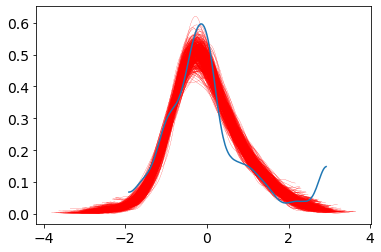

In [29]:
Ypred = ppc(posterior_3['alpha'],posterior_3['beta'],posterior_3['sigma_n'],X_train3_n,  nsamples=500)
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Y_train3_n);

In [30]:
#compute LOO
model_3_loo = pm.loo(posterior_3)
model_3_loo

Computed from 8000 by 404 log-likelihood matrix

         Estimate       SE
elpd_loo  -327.43    22.72
p_loo        7.14        -

In [31]:
print(model_1_loo,model_2_loo,model_3_loo)

Computed from 8000 by 404 log-likelihood matrix

         Estimate       SE
elpd_loo  -361.40    22.33
p_loo        8.09        - Computed from 8000 by 404 log-likelihood matrix

         Estimate       SE
elpd_loo  -383.16    23.18
p_loo        7.31        - Computed from 8000 by 404 log-likelihood matrix

         Estimate       SE
elpd_loo  -327.43    22.72
p_loo        7.14        -


**Best model is number=3**

### Model averaging
So far we have seen posterior-predictive checks and model selection via model evidence.
Now we will instead use model averaging.

We will combine two bad models to get a better one.

In [32]:
with pm.Model() as model_1:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=X_train1_n.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
  
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, X_train1_n.T)
    #likelihood
    #case 1
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=Y_train1_n[:,0])# be sure that observed is a 1d vector
    #compute posterior
    posterior_1 = pm.sample(4000, tune=2000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma_n, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:04<00:00, 2423.93draws/s]


In [33]:
with pm.Model() as model_2:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=X_train2_n.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
  
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, X_train2_n.T)
    #likelihood
    #case 1
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=Y_train2_n[:,0])# be sure that observed is a 1d vector
    #compute posterior
    posterior_2 = pm.sample(4000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma_n, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2151.32draws/s]


In [40]:
#compute model evidence, that is log(p(data|M_i))
model_1_loo = pm.loo(posterior_1)
model_2_loo = pm.loo(posterior_2)
print("LOO model 1:", model_1_loo[0])
print("LOO model 2:", model_2_loo[0])

LOO model 1: -417.63925488565314
LOO model 2: -416.7437763234409


In [ ]:
We will use the estimate LOO as pseudo-weights to combine the two models. 

In [41]:
v=np.array([ model_1_loo[0], model_2_loo[0]])
# we compute the exp by using the log-sum-exp trick 
# see https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/
w=np.exp(v-(np.max(v)+np.log(np.sum(np.exp(v-np.max(v))))))
w

array([0.28998054, 0.71001946])

Text(0.5, 1.0, 'model averaging')

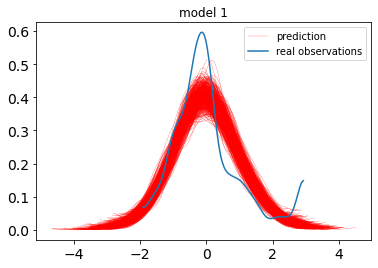

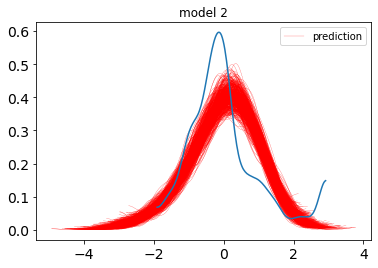

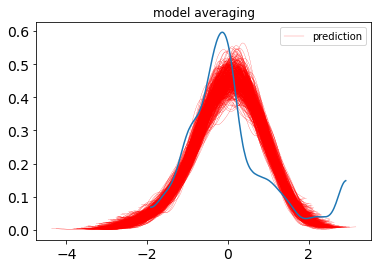

In [42]:
Ypred1 = ppc(posterior_1['alpha'],posterior_1['beta'],posterior_1['sigma_n'],X_train1_n,  nsamples=500)
Ypred2 = ppc(posterior_2['alpha'],posterior_2['beta'],posterior_2['sigma_n'],X_train2_n, nsamples=500)
Ypred=Ypred1*w[0]+Ypred2*w[1]

plt.figure()
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(Y_train2_n,label="real observations");
plt.legend();
plt.title("model 1")
plt.figure()
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(Y_train2_n);
plt.title("model 2")
plt.figure()
for i in range(Ypred.shape[0]):
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(Y_train2_n);
plt.title("model averaging")

You can see that the averaged model is better than both. Averaging usually provides much better performance than model selection.